In [292]:
import duckdb
import pandas as pd

def sql(query):
    con = duckdb.connect('../data/db/amazon_2025-07-16.db')
    res = con.execute(query).df()
    con.close()
    return res

sql("SHOW TABLES")

,name
0,products


In [293]:
class_jour = sql(""" SELECT * from products""")
class_jour["url_cliquable"] = class_jour["url"].apply(
    lambda x: f'<a href="{x}" target="_blank">Voir le produit</a>' if pd.notna(x) else ""
)
print(f"nb de lignes {len(class_jour)}")
print(f"Colonnes : {class_jour.columns.to_list()}")

nb de lignes 4800
Colonnes : ['title', 'price', 'rating', 'votes', 'sales_last_month', 'image_url', 'url', 'prime', 'scraped_at', 'categorie', 'published_date', 'full_title', 'categorie_principale', 'categorie_secondaire', 'url_cliquable']


In [294]:
from IPython.display import display, HTML

def afficher_produit_depuis_url(df, idx):
    ligne = df[df.index == idx]
    if ligne.empty:
        print("❌ Aucun produit trouvé avec cette URL.")
        return

    for _, row in ligne.iterrows():
        html = f"""
        <h3>{row['title']}</h3>
        <a href="{row['url']}" target="_blank">🔗 Lien vers le produit</a><br><br>
        <a href="{row['image_url']}" target="_blank">
            <img src="{row['image_url']}" height="150">
        </a>
        """
        display(HTML(html))

In [295]:
class_jour.head()

,title,price,rating,votes,sales_last_month,image_url,url,prime,scraped_at,categorie,published_date,full_title,categorie_principale,categorie_secondaire,url_cliquable
0,"DJI Osmo Pocket 3 Créateur Bundle, camera vlog...",679.00,4.6,5304.0,500.0,https://m.media-amazon.com/images/I/51mX1K3tM0...,https://www.amazon.fr/DJI-Cr%C3%A9ateur-Vloggi...,0,2025-07-16 11:27:19.223952,"['High-Tech', 'Photo et caméscopes', 'Caméras ...",25 octobre 2023,"DJI Osmo Pocket 3 Créateur Bundle, camera vlog...",438 en High-Tech ( Voir les 100 premiers en Hi...,2 en Caméras embarquées,"<a href=""https://www.amazon.fr/DJI-Cr%C3%A9ate..."
1,"DJI Bundle Essentiel Osmo Action 5 Pro, Caméra...",279.00,4.5,1709.0,400.0,https://m.media-amazon.com/images/I/71LN4iT1Pq...,https://www.amazon.fr/DJI-Essentiel-%C3%89tanc...,0,2025-07-16 11:27:19.224678,"['High-Tech', 'Photo et caméscopes', 'Appareil...",24 février 2025,"DJI Bundle Essentiel Osmo Action 5 Pro, Caméra...",732 en High-Tech ( Voir les 100 premiers en Hi...,2 en Caméras étanches,"<a href=""https://www.amazon.fr/DJI-Essentiel-%..."
2,Garmin – Forerunner 55 - Montre GPS multi-acti...,0.00,4.6,6642.0,900.0,https://m.media-amazon.com/images/I/61eTqEILa9...,https://www.amazon.fr/Garmin-Forerunner-multi-...,0,2025-07-16 11:27:19.225583,"['Sports et Loisirs', 'Électronique', 'GPS', '...",16 juin 2021,Garmin – Forerunner 55 - Montre GPS multi-acti...,44 en Sports et Loisirs ( Voir les 100 premier...,1 en GPS de running,"<a href=""https://www.amazon.fr/Garmin-Forerunn..."
3,"Insta360 X5 - caméra d'action 360° 8K étanche,...",589.99,4.5,740.0,300.0,https://m.media-amazon.com/images/I/61m2oUob8N...,https://www.amazon.fr/Insta360-Invisible-rempl...,0,2025-07-16 11:27:19.226311,"['High-Tech', 'Photo et caméscopes', 'Caméras ...",22 avril 2025,"Insta360 X5 - caméra d'action 360° 8K étanche,...",1 051 en High-Tech ( Voir les 100 premiers en ...,6 en Caméras embarquées,"<a href=""https://www.amazon.fr/Insta360-Invisi..."
4,Insta360 X5 Pack Essentiels - caméra d'action ...,699.99,4.5,740.0,300.0,https://m.media-amazon.com/images/I/71NlchaTFy...,https://www.amazon.fr/Insta360-Pack-Essentiels...,0,2025-07-16 11:27:19.227026,"['High-Tech', 'Photo et caméscopes', 'Caméras ...",22 avril 2025,Insta360 X5 Pack Essentiels - caméra d'action ...,1 053 en High-Tech ( Voir les 100 premiers en ...,7 en Caméras embarquées,"<a href=""https://www.amazon.fr/Insta360-Pack-E..."


In [296]:
print(f"Colonnes dupliquées supprimées: {len(class_jour[class_jour['title'].duplicated()])}")

class_jour= class_jour.drop_duplicates(subset='title')

Colonnes dupliquées supprimées: 406


In [297]:
class_jour.shape

(4394, 15)

In [ ]:
import re
import unicodedata

def clean_title(txt: str)->str:
    if pd.isna(txt) : 
        return ""
    else:
        txt = txt.lower()
        txt = re.sub(r'\s+', ' ', txt).strip()
        txt = unicodedata.normalize("NFKD", txt).encode("ascii", "ignore").decode()
        return txt



class_jour['title_clean'] = class_jour['title'].apply(clean_title)

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

STOP_FR = stopwords.words('french')

vec = TfidfVectorizer(
        ngram_range=(1,4),
        min_df=2,
        max_df=0.0025,
        stop_words=STOP_FR
)


X = vec.fit_transform(class_jour['title_clean'])
print("Forme de la matrice :", X.shape)        # (4800, vocabulaire)
print("Extraits du vocabulaire :", vec.get_feature_names_out()[:20])

Forme de la matrice : (4394, 29287)
Extraits du vocabulaire : ['00' '00 paquet' '000304' '00147' '01' '010' '02' '03' '08' '09c'
 '09c color' '0in' '10 11' '10 130' '10 130 20000' '10 130 20000 hz'
 '10 49' '10 49 46' '10 49 46 45' '10 batterie']


In [299]:
#----------------------------------HDBSCAN------------------------------------
import hdbscan

clusterer = hdbscan.HDBSCAN(
            min_cluster_size=2,
            min_samples=1,
            metric='cosine',
            cluster_selection_method='eom'
)
labels = clusterer.fit_predict(X)         # X : matrice sparse
class_jour["cluster_id"] = labels
print(f"Nombre de clusters trouvés : {len(class_jour["cluster_id"].value_counts())}")
print(class_jour["cluster_id"].value_counts().head())

/Users/remybordes/Documents/WildCodeSchool/NicheFinder/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nombre de clusters trouvés : 1349
cluster_id
-1       477
 1088     10
 808      10
 16        9
 1056      9
Name: count, dtype: int64


In [300]:
def taille_cluster(id):
    return class_jour['cluster_id'][class_jour['cluster_id'] == id].count()


class_jour['taille_cluster'] = class_jour['cluster_id'].apply(taille_cluster)
class_jour[class_jour['taille_cluster'] <= 800].sort_values(by='taille_cluster', ascending=False).head(3)

,title,price,rating,votes,sales_last_month,image_url,url,prime,scraped_at,categorie,published_date,full_title,categorie_principale,categorie_secondaire,url_cliquable,title_clean,cluster_id,taille_cluster
2403,Xuniu Membranes de Vibration auxiliaires à dia...,13.49,5.0,1.0,NaN,https://m.media-amazon.com/images/I/61fErnDEZz...,https://www.amazon.fr/Xuniu-Membranes-Vibratio...,0,2025-07-16 11:34:20.112250,['nan'],None,None,None,None,"<a href=""https://www.amazon.fr/Xuniu-Membranes...",xuniu membranes de vibration auxiliaires a dia...,-1,477
1341,Philips Hue Piquet au Sol pour caméra Secure,39.00,4.5,2.0,NaN,https://m.media-amazon.com/images/I/51WKcdSEdM...,https://www.amazon.fr/Philips-Hue-Piquet-Cam%C...,0,2025-07-16 11:31:11.681300,['nan'],None,None,None,None,"<a href=""https://www.amazon.fr/Philips-Hue-Piq...",philips hue piquet au sol pour camera secure,-1,477
818,Casque de réalité virtuelle avec contrôleur et...,62.98,2.8,27.0,NaN,https://m.media-amazon.com/images/I/71KRHTcrjp...,https://www.amazon.fr/virtuelle-contr%C3%B4leu...,0,2025-07-16 11:29:44.784545,"['High-Tech', 'Téléphones portables et accesso...",21 juillet 2024,Casque de réalité virtuelle avec contrôleur et...,105 169 en High-Tech ( Voir les 100 premiers e...,59 en Casques de réalité virtuelle (VR) pour t...,"<a href=""https://www.amazon.fr/virtuelle-contr...",casque de realite virtuelle avec controleur et...,-1,477


In [301]:
class_jour['cluster_id'][1707]

np.int64(-1)

In [302]:
# Comptage des clusters par taille décroissante
cluster_counts = class_jour["cluster_id"].value_counts().sort_values(ascending=False)

# Parcours des clusters les plus gros en premier
for cid, count in cluster_counts.items():
    print(f"\nCluster {cid} – {count} titres")
    titres = class_jour.loc[class_jour["cluster_id"] == cid, "title"].head(15)
    for t in titres:
        print(" •", t)


Cluster -1 – 477 titres
 • Insta360 GO 3S Noir Minuit (128GB) - Petite caméra de vlog 4K, POV Mains Libres, Montage Partout, stabilisation, 140 Min d'autonomie, étanche à 10 m, édition IA, pour Voyage, vlog
 • Xiaomi Redmi Note 14 Pro Plus 5G Smart Phone, 8GB RAM 256 GB, Pantalla AMOLED de 6,67'', Sensor de Huellas, Cámara de 200 MP, NFC, Cargador no Incluido, Color Lavender Purple
 • Insta360 Ace Pro 2 Pack Xplorer caméra d'action étanche 8K, co-conçue avec Leica, capteur 1/1,3", double puce d'IA, performance de pointe en basse lumière, audio de qualité supérieure, Double Batterie
 • Echo Pop | Anthracite, pack de 2 + Tapo L530EA ampoule connectée LED (E27), Fonctionne avec Alexa - Kit de démarrage Maison connectée
 • Casque Bluetooth sans Fil,Casque Bluetooth Over-Ear, stéréo Pliables sans Fil et Filaire Écouteurs avec Microphone intégré, Micro SD/TF, FM pour Phone/Samsung/iPad/PC/Laptops
 • COROS Pace Pro Montre GPS de Sport, écran Tactile AMOLED de 1,3 Pouce, Notre processeur Le P

In [304]:
from nltk.corpus import stopwords
print(stopwords.words("french"))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [180]:
# Choisis un identifiant dans la liste (ex. 665.0)
cid = 622
print(f"\nCluster {cid} – {len(class_jour[class_jour.cluster_id == cid])} titres")
for t in class_jour.loc[class_jour["cluster_id"] == cid, "title"].head(15):
    print(" •", t)


Cluster 622 – 3 titres
 • HUE HD Pro : Visualiseur de Documents et Caméra USB Flexible de Visioconférence (Noir) avec Etui de Transport (Noir)
 • HUE HD Pro : Visualiseur de Documents et Caméra USB Flexible de Visioconférence (Bleu) avec Etui de Transport (Blanc)
 • HUE HD Pro : Visualiseur de Documents et Caméra USB Flexible de Visioconférence (Rouge) avec Etui de Transport (Blanc)


In [ ]:
# Choisis un identifiant dans la liste (ex. 665.0)
import random

cid = random.choice(class_jour["cluster_id"].unique().tolist())

print(f"\nCluster {cid} – {len(class_jour[class_jour.cluster_id == cid])} titres")
for t in class_jour.loc[class_jour["cluster_id"] == cid, "title"].head(15):
    print(" •", t)

<Axes: xlabel='cluster_id', ylabel='count'>

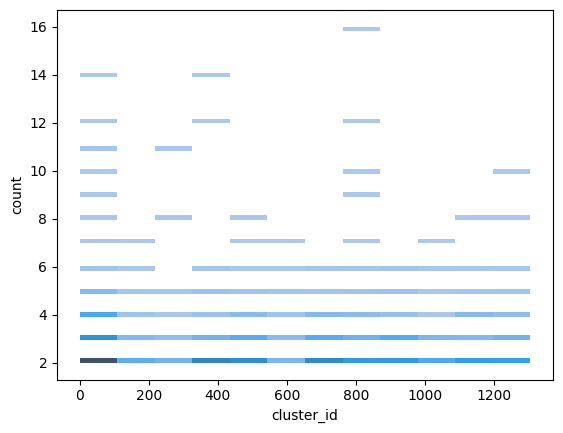

In [167]:
import seaborn as sns
import matplotlib.pylab as plt

sns.histplot(class_jour, x = class_jour['cluster_id'], y = class_jour['cluster_id'].value_counts())

(0.0, 50.0)

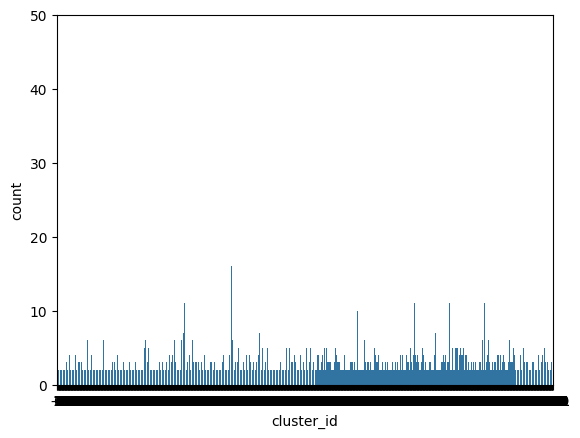

In [168]:
sns.countplot(class_jour, x = 'cluster_id')
plt.ylim(top=50)

In [143]:
import pandas as pd
import re
import unicodedata

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import hdbscan

# -----------------------------
# A. Nettoyage
# -----------------------------
def clean_text(txt):
    if pd.isna(txt):
        return ""
    txt = txt.lower()
    txt = re.sub(r"\s+", " ", txt).strip()
    txt = unicodedata.normalize("NFKD", txt).encode("ascii", "ignore").decode()
    return txt

# Nettoyage des deux colonnes
class_jour["title_clean"] = class_jour["title"].apply(clean_text)
class_jour["categorie_clean"] = class_jour["categorie"].apply(clean_text)

# -----------------------------
# B. Vectorisation TF-IDF
# -----------------------------
STOP_FR = stopwords.words('french')

vec_title = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.5, stop_words=STOP_FR)
vec_cat   = TfidfVectorizer(ngram_range=(1, 1), min_df=1, stop_words=STOP_FR)

X_title = vec_title.fit_transform(class_jour["title_clean"])
X_cat   = vec_cat.fit_transform(class_jour["categorie_clean"])

# -----------------------------
# C. Fusion pondérée (poids cat)
# -----------------------------
poids_cat = 1.0   # ← Tu peux ajuster ce facteur
X_final = hstack([X_title, X_cat * poids_cat])

# -----------------------------
# D. Clustering avec HDBSCAN
# -----------------------------
clusterer = hdbscan.HDBSCAN(
            min_cluster_size=2,
            min_samples=1,
            metric='cosine',
            cluster_selection_method='eom'
)

class_jour["cluster_id"] = clusterer.fit_predict(X_final)

# -----------------------------
# E. Résultat
# -----------------------------
print("Extrait des clusters détectés :")
print(class_jour["cluster_id"].value_counts().head(10))

/Users/remybordes/Documents/WildCodeSchool/NicheFinder/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Extrait des clusters détectés :
cluster_id
-1       1267
 399       19
 232       13
 691       11
 662       10
 921       10
 84        10
 1121       9
 544        9
 102        9
Name: count, dtype: int64


In [291]:
afficher_produit_depuis_url(class_jour, 1410)

/Users/remybordes/Documents/WildCodeSchool/NicheFinder/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


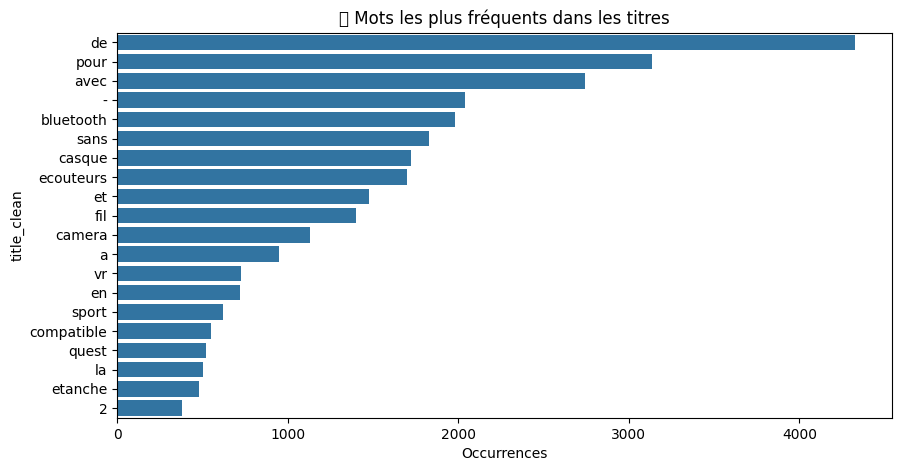

In [303]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Exemple : top mots clés dans les titres (unigrammes)
mots = class_jour['title_clean'].str.split().explode()
top_mots = mots.value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=top_mots.values, y=top_mots.index)
plt.title("🔍 Mots les plus fréquents dans les titres")
plt.xlabel("Occurrences")
plt.show()

/Users/remybordes/Documents/WildCodeSchool/NicheFinder/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


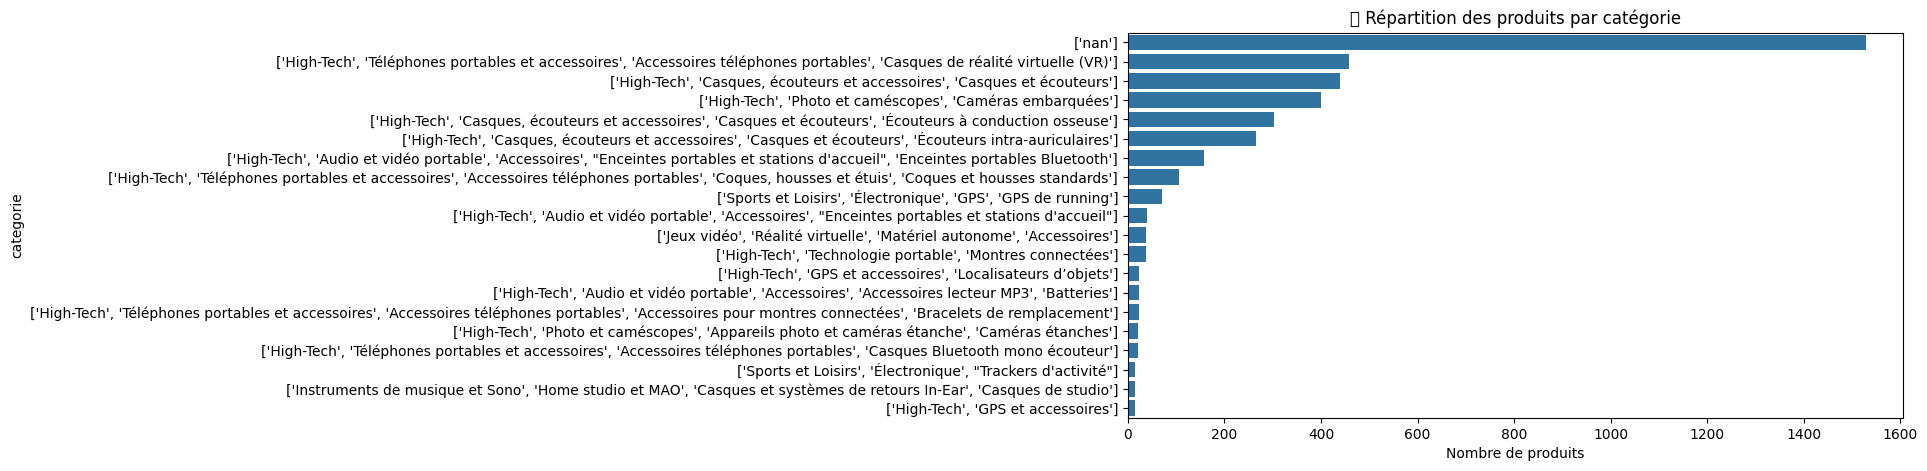

In [305]:
top_cat = class_jour['categorie'].explode().value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=top_cat.values, y=top_cat.index)
plt.title("📦 Répartition des produits par catégorie")
plt.xlabel("Nombre de produits")
plt.show()

In [ ]:
#----------------------------------SHIT------------------------------------

In [ ]:
#----------------------------------AgglomerativeClustering------------------------------------
#Trop long (15min) et résultats moyennement concluant,
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.70,   # ajuste entre 0.65 et 0.75 selon le résultat
    metric="cosine",           # anciennement affinity="cosine"
    linkage="average"
)

#class_jour["cluster_id"] = clusterer.fit_predict(X.toarray()).      enlevez # pour tester

# Aperçu : top 10 des tailles de clusters
print(f"Nombre de clusters trouvés : {len(class_jour["cluster_id"].value_counts())}")
print("Tailles des 10 plus grands clusters :")
print(class_jour["cluster_id"].value_counts().head(10))

In [37]:
class_jour['categorie'][0]

"['High-Tech', 'Photo et caméscopes', 'Caméras embarquées']"

In [ ]:
#----- tri classement ------

hist_class = pd.DataFrame({})

for i in class_jour.index : 
    row = class_jour[['titre','url', 'classement']].loc[[i]]
    if row.notna().all(axis= 1).iloc[0] :
        hist_class = pd.concat([row, hist_class])
    else : 
        continue
    

hist_class

,titre,url,classement
4557,KOAIEZ Écouteurs De Sport À Oreille Ouverte av...,https://www.amazon.fr/KOAIEZ-%C3%89couteurs-Co...,[]
4556,"Diyeeni Collier de Caméra pour Chat, Caméra po...",https://www.amazon.fr/Diyeeni-Objectif-Corpore...,[]
4438,LONLI Hue - pour étui iPhone 16 Plus - étui de...,https://www.amazon.fr/LONLI-Hue-t%C3%A9l%C3%A9...,[]
4395,"Maglens-Caméra de Sport et D'activité, Visusca...",https://www.amazon.fr/Maglens-Cam%C3%A9ra-Spor...,[]
4323,Moondrop Golden Ages TWS Écouteurs 13 mm Full ...,https://www.amazon.fr/Moondrop-Golden-Ages-Mul...,[]
...,...,...,...
4,Disjoncteur WIFI intelligent Interrupteur Conn...,https://www.amazon.fr/Interrupteur-Commutateur...,[]
3,Yinyoo KZ EDX Pro Écouteurs filaires avec Micr...,https://www.amazon.fr/%C3%89couteurs-EDX-Pro-a...,"[(313844, 'High-Tech'), (6886, 'Casques et éco..."
2,Xmenha Écouteurs Bluetooth Écran Touché Contrô...,https://www.amazon.fr/Xmenha-%C3%89couteurs-Bl...,"[(537836, 'High-Tech'), (2869, 'Écouteurs à co..."
1,OMRON RS3 Intelli IT tensiomètre automatique a...,https://www.amazon.fr/Tensiom%C3%A8tre-OMRON-C...,"[(6008, 'Hygiène et Santé'), (33, 'Tensiomètre..."


In [ ]:
import scikit-learn 